### Introduction to Ethereum's EIP-1559 and legacy transaction fee markets in general 

#### How does the Ethereum blockchain works with miners?

- In a blockchain, specifically Ethereum in our case, a **Proof of Work** (POW) blockchain, transactions are packed into **blocks** which are interconnected in a sequential manner. 

- The person putting the transactions together is known as a **miner** and uses computational resources to bundle transactions, process the transactions and keep the chain growing. The cost of this can be very high.

- Users submitting the transactions gives the miners a monetary reward for including their transactions in the next block. This is in the form of transaction fees that the user submitting the transaction pays, and is called the **gas price**.

- The space occupied in a blockchain is measured in a unit known as **gas** and the **gas price** is essentially the transaction fee per **unit gas** occupied by the transaction.

- Some transactions are fairly simple (E.g: Simple cryptocurrency transfers) while some of them are more complex (E.g: Transactions that store data from an application which is built on the blockchain). The simpler ones take up lesser space, while the more complex ones take up more space. 

- Miners are now economically incentivized to include and process transactions in the block, with hopes of their earnings from the tips being greater than their initial investment to keep maintain and add blocks to the Ethereum chain in a decentralized manner.

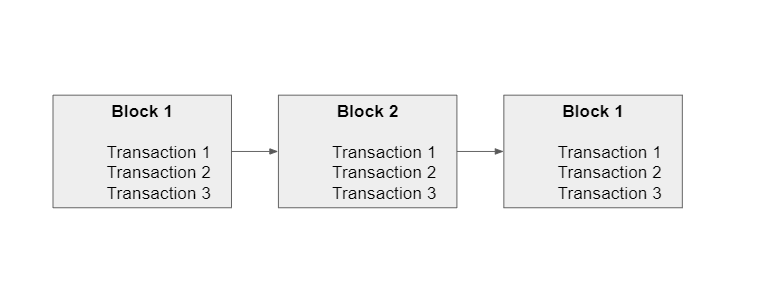

#### Old system:

- In the old system, the process of paying tips to get your transaction included in a block resembles a **first price auction** system.
- The higher gas price which the user was willing to pay for inclusion of transaction in a block, the more likely his/her's transaction is included in the next block to be processed.

#### Drawbacks of the old system: 

- Over bidding for inclusion
- Unfairly pricing out users that cannot afford high gas prices during certain periods of time

Moreover, previously the economic value captured by the use of network (the protocol fee) was awarded to the miner. This would thus the protocol fee wasn't be very binding. It could therefore lead to unfair bidding in scenarios where for instance the miner could offer rebates by subsidising a transaction and sharing revenue with the user.


#### New system:

- Under EIP-1559, it aimed to address these abovementioned issues by introducing a dynamically adjusted **base-fee** which is dependent on market conditions. This means transaction fees are now split into 2 components: basefee and **miner's tip** 
- When a user submits a transaction they will need to specify: what tip are they willing to pay, what is the maximum transaction fees they are willing to pay for inclusion (tip, maxfee)
- The basefee is calculated by the system based on a simple forumla as given below:

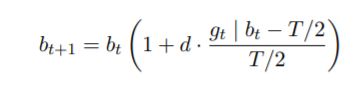

- In the above formula, `bt+1` is the base-fee at time (t+1) and `bt` the basefee at time (t), `gt|bt` is the number of transactions included in the block produced at time (t), `d` is a constant and `T/2` is the target block size (The block size that the system aims to achieve **on average**)
- The idea behind this upgrade is that the basefee increases when the space occupied by the transactions exceeds the target blocksize thereby making it more expensive for transactions to be included in the next block. Consequently when the space occupied by the transactions is lesser than the target blocksize, it becomes cheaper for transactions to get included in the next block.
- The equivalent to the gasprice in the old system is the `min(basefee + tip , maxfee)`
- The basefee is burnt (i.e removed out of circulation), since this is now represents the economic value that is catured by the use of the network. This way untruthful bidding is now disincentivized. 
- The final fees that reaches the miner is: `min(maxfee - basefee , tip)`.


#### The objective of eip-1559 are as follows: 

- Prevention of untruthful bidding
- To allow for more flexibility during changing market conditions by aiming for a longterm average target block size (half-full blocks) instead of blocks that are consistently full
- Making transaction fees more predictable (But not neccessarily lower)

#### Drawbacks of eip-1559:

One of the changes that this upgrade introduced to the protocol was that it increased the block size limit by a factor of 2X

- The biggest critiques against eip-1559 is that theoretically by doing so, there will be a lot of variance in block size 
  

### Reference

Reijsbergen, D., Sridhar, S., Monnot, B., Leonardos, S., Skoulakis, S., & Piliouras, G. (2021). Transaction Fees on a Honeymoon: Ethereum's EIP-1559 One Month Later. _arXiv preprint arXiv:2110.04753._ [[arXiv link]](https://arxiv.org/pdf/2110.04753.pdf)

Leonardos, S., Monnot, B., Reijsbergen, D., Skoulakis, S., & Piliouras, G. (2021). Dynamical Analysis of the EIP-1559 Ethereum Fee Market. _arXiv preprint arXiv:2102.10567._ [[arXiv link]](https://arxiv.org/pdf/2102.10567.pdf)

Robust Incentives Group, Ethereum Foundation. abm1559: Agent-based simulation environment for EIP 1559 notebooks. [[Online]](https://ethereum.github.io/abm1559/)

### Objectives of our simulation model:

Since EIP-1559 is a very new proposal and has very recently been implemented, our simulation is more exploratory in nature in order for us to get a better understanding of how different system parameters evolve over time. It is less of an evaluvation but more of design tradeoffs. 

However, that being said, the system has a target for the long term average block size. Most work that has been done so far aims to assess **theoretically** if this target can be met. We aim to do so emperically through our model. 

We would also want to get a rough estimate of the economic value that is captured by using the Ethereum blockchain. 

We thus build two baseline models to:

1) Visualize and see how the gas price and other componenets of EIP-1559 transactions (The baseefee, tip and maxfee) evolve in a single simulation run for both systems 
2) Visualize how the block size varies for both systems in a single simulation run 
3) Perform output analysis to: 
    - Analyze and see if the long-term average block size under EIP-1559 meets the required target size 
    - Get an estimate of the economic value that is captured by the use of the protocol. We do this by looking at the basefee

Consequently we will use realtime data extracted from the blockchain and use it as an input to our two models and re-visit the objectives by simulating a more realistic situation 

### How our simulation works in general with state diagram
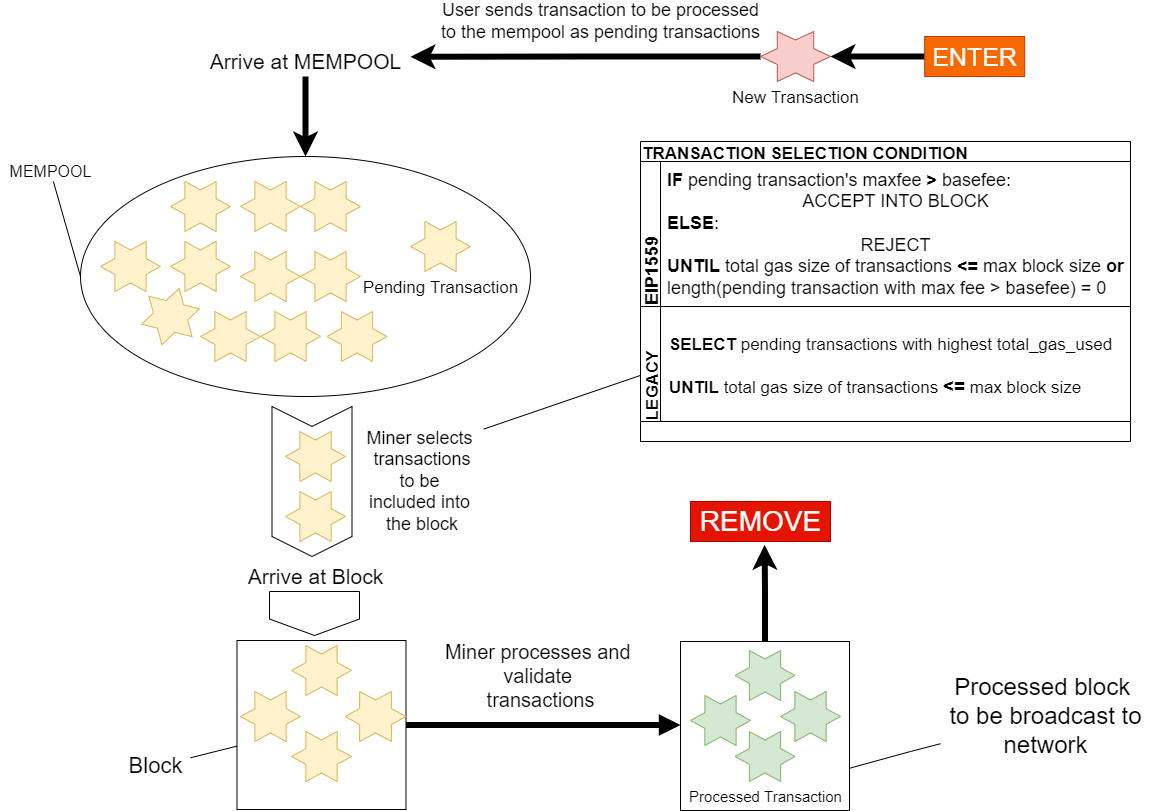

#### In every time step:

1) New transactions submitted towards the blockchain, which are class objects (EIP1559 model: `eip1559_transaction`, Legacy model: `legacy_transactions` ), are created via demand functions (EIP1559 model: `demand_functions_eip1559`, Legacy model: `demand_functions_legacy`).
2) These transactions are 'sent' to the MEMPOOL, which holds these pending transactions in the `demand_dict` dictionary object within the demand functions
3) 'Miners' selects pending transactions within the MEMPOOL to be included the a class object,`block`, through the transaction selection functions (EIP1559 model: `transaction_selection_eip1559`, Legacy model: `transaction_selection_legacy`)
4) Pending transactions within each block is 'processed' by miner under the transaction selection functions and processed block is 'broadcasted to network' via the updating of global variables within the `initial_state` variable to be used in the next timestep via the functions `update_basefee` and `record_latest_block` (EIP1559 model: both functions, Legacy model: only `record_latest_block`)
5) Repeat steps above for next time step.

P.S. Classes, objects, variables and functions mentioned here are discussed below under the code

### Housekeeping

We first import all the necessary modules required to make the simulation run

In [1]:
!git clone -b sma_realtime_data https://github.com/SHSR2001/abm1559.git
%cd abm1559
!pip install -r requirements.txt
!pip install matplotlib

c:\Users\Admin\Desktop\SUTD\ESD\T6\SMA\abm1559\sma_project\abm1559


Cloning into 'abm1559'...
Updating files:  91% (90/98)
Updating files:  92% (91/98)
Updating files:  93% (92/98)
Updating files:  94% (93/98)
Updating files:  95% (94/98)
Updating files:  96% (95/98)
Updating files:  97% (96/98)
Updating files:  98% (97/98)
Updating files: 100% (98/98)
Updating files: 100% (98/98), done.


In [2]:
# from functions import *
import random
import secrets
import pandas as pd
import numpy as np
from radcad import Model, Simulation, Experiment
from radcad.engine import Engine, Backend
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

### Constants

We first define all the constants in our model and store them in a dictionary. These are parameters that are intrinsic to the system and cannot be changed. 

#### For the new system they are:

- The `TARGET_SIZE` which is the target size that the system aims to achieve on average 
- The `MAX_BLOCK_SIZE` that is the maximum size that each block can be according to the new system
- The `BASEFEE_MAX_CHANGE_DENOMINATOR` which captures the constant `d` in the base fee update rule we previously mentioned above under basefee calculation

For the old system they are:

- The `MAX_BLOCK_SIZE` that is the maximum size that each block can be according to the old system

We have also defined some constants which we can change in our simulation model. They are:

- The `mempool_length` which is the size limit of the queue that holds all transactions 
- The `INITIAL_BASEFEE` which is the initial value to which the baseefee is instantiated 

In [3]:
## Constants

constants_eip1559 = {
    "BASEFEE_MAX_CHANGE_DENOMINATOR": 8,
    "TARGET_SIZE": 12500000,
    "MAX_BLOCK_SIZE": 25000000
}

constants_legacy = {
    "MAX_BLOCK_SIZE": 12500000,
}

levers = {
    "mempool_length": 1500
}

### Classes

We move on to define 3 classes:

`eip1559_transaction`:

- In the new system each transaction has 4 components: The `total_gas_used` which is the total space the transaction occupies, the `fee_cap`: the maxfee, the `premium`: the tip and the `transaction_hash` which is the identity for the transaction (it also involves some complex cryptography magic)

`legacy_transaction`:

- In the old system we just have the: `total_gas_used`, the `transaction_hash` and the `fee` which is the gas price

`block`:

- Simply the block containing the transactions `transactions` which is of a fixed size `size`
- We also store the average gas price of all the transactions in the block in `avg_gas_price`

In [4]:
## Classes

class eip1559_transaction:
    def __init__(self,total_gas,fee_cap,premium):
        
        # Inherent txn propoerties 
        self.total_gas_used = total_gas
        self.transaction_hash = secrets.token_bytes(8)
        
        # User adjusted txn properties
        self.fee_cap = fee_cap
        self.premium = premium
        
class legacy_transaction:
    def __init__(self,total_gas,fee):
        
        # Inherent txn properties
        self.total_gas_used = total_gas
        self.transaction_hash = secrets.token_bytes(8)
        
        # User adjusted txn properties 
        self.fee = fee
        
class block:
    def __init__(self,size,transactions, avg_gas_price):
        self.size = size
        self.transactions = transactions 
        self.avg_gas_price = avg_gas_price

### Functions

`demand_functions_eip1559` and `demand_functions_legacy`:

We have defined the functions for demand for each of the systems. For now we assume that:

- The transactions which are submitted are of a random size between: 2000 and 3000 
- The `gasprice` in the case of legacy and `fee_cap` in the case of EIP1559 ascociated with the transactions are also random in the range ($1*10^{9}$ to $11*10^{9}$) 
- The `premium` in the case of EIP1559 is a random variable too, in the range of ($0*10^{9}$ to $2*10^{9}$)
    - These are based on the most commonly seen ranges in practice 
- Transactions do not have a limit on how long it can stay in the mempool. The first step is to therefore take the previous demand and remove all transactions that have been included in the previous block from it.
- The next step is to carry over the resultant demand and add any new transactions to it. 
    
`transaction_selection_eip1559` and `transaction_selection_legacy`:

We have defined the functions for how the miners select which transactions get included in the next block. We simulate the most common strategy: Fill the block to the brim and make as much profit as possible

The steps are something like this:

- Process each transaction and sort them by the (gas price/space they occupy). 
- Given the space taken up by each of these transactions, select as many as possible keeping in mind the `MAX_BLOCK_SIZE`
- Pack everything up in a block and propogate that to the rest of the network 

This is very similar to a knapsack problem. The only difference between the two systems is that the gas prices are different: `min(fee_cap - basefee , premium)` vs just the `fee`

`update_basefee`:

- This is a function that updates the basefee for the next timestep given the basefee from the previous timestep, the constant parameter `BASEFEE_MAX_CHANGE_DENOMINATOR` and the `TARGET_SIZE`
            
`record_latest_block`:

- This is a function that all agents in the network uses to record the latest block that has been produced


In [6]:
## Using common random variables -----> this is to increase the precision of simulation results when comparing 2 models

rand = []
rand_lst = []

for i in range(1000000):
    a = random.randint(0,2)
    b = a + random.randint(1,9)
    c = random.randint(20000,30000)
    
    rand.append((a,b))
    rand_lst.append(c)

In [7]:
## Functions 

def demand_functions_eip1559(params, substep, state_history, previous_state, policy_input):
    
    number_of_transactions_in_mempool = levers['mempool_length']
    
    demand_dict = previous_state['demand']
    previous_block = previous_state["latest_block"]
    
    n_row = previous_state['n_row']
    
    if len(previous_block.transactions) > 0:
        for tx in previous_block.transactions:
            demand_dict.pop(tx.transaction_hash)
    
#     a = random.randint(0,2)
#     b = a + random.randint(1,9)
    
    for i in range(n_row, n_row + number_of_transactions_in_mempool):
        
        temp = rand[i]
        
        a = temp[0]
        b = temp[1]
        
        tx = eip1559_transaction(
            total_gas = rand_lst[i],
            premium = a*(10**9),
            fee_cap = b *(10**9)
        )
        demand_dict[tx.transaction_hash] = tx
        
        print("New transaction {}, submitted into the mempool".format(tx.transaction_hash))
    
    return ("demand", demand_dict)

def demand_functions_legacy(params, substep, state_history, previous_state, policy_input):
    
    number_of_transactions_in_mempool = levers['mempool_length']
    
    demand_dict = previous_state['demand']
    previous_block = previous_state["latest_block"]
    
    n_row = previous_state['n_row']
    
    for tx in previous_block.transactions:
        demand_dict.pop(tx.transaction_hash)
    
    #a = random.randint(1,3)
    
    for i in range(n_row, n_row + number_of_transactions_in_mempool):
        
        temp = rand[i]
        
        b = temp[1]
        
        tx = legacy_transaction(
            total_gas = rand_lst[i],
            #premium = a*(10**9),
            fee = b * (10 ** 9)
        )
        demand_dict[tx.transaction_hash] = tx
        
        print("New transaction {}, submitted into the mempool".format(tx.transaction_hash))
    
    return ("demand", demand_dict)


def transaction_selection_eip1559(params, substep, state_history, previous_state):
    
    demand_dict = previous_state["demand"] #simulates the MEMPOOL which is also the demand_dict returned at demand_function_eip
    basefee = previous_state["basefee"]
    
    size = constants_eip1559["MAX_BLOCK_SIZE"]
    final_fee_transactions = {}
    final_gas_prices = {}
    
    for i in demand_dict.keys():
        if basefee > demand_dict[i].fee_cap:
            continue
        else:
            final_fee_transactions[i] = (min(demand_dict[i].fee_cap - basefee, demand_dict[i].premium))/demand_dict[i].total_gas_used
            final_gas_prices[i] = min(basefee + demand_dict[i].premium, demand_dict[i].fee_cap)
            
    final_fee_transactions = dict(sorted(final_fee_transactions.items(), key=lambda x: x[1], reverse=True))
    
    included_transactions = []
    total_size_used = 0
    gas_fee_total = []
    
    for i in final_fee_transactions.keys():
        
        if total_size_used < size:
            included_transactions += [demand_dict[i]]
            total_size_used += demand_dict[i].total_gas_used
            gas_fee_total.append(final_gas_prices[i])
        
    print("{} Number of transactions being included in the next block".format(len(included_transactions)))
    
    if(len(gas_fee_total) == 0):
        avg_gas_price = 0
    else:
        avg_gas_price = sum(gas_fee_total)/len(gas_fee_total)
        
    return { "block": block(size = total_size_used, transactions = included_transactions, avg_gas_price = avg_gas_price)}
        
def transaction_selection_legacy(params, substep, state_history, previous_state):
    
    demand_dict = previous_state["demand"] #simulates the MEMPOOL which is also the demand_dict returned at demand_function_legacy
    
    size = constants_legacy["MAX_BLOCK_SIZE"]
    final_fee_transactions = {}
    
    for i in demand_dict.keys():
            final_fee_transactions[i] =  (demand_dict[i].fee/demand_dict[i].total_gas_used)    
            
    final_fee_transactions = dict(sorted(final_fee_transactions.items(), key=lambda x: x[1], reverse=True))
    
    included_transactions = []
    total_size_used = 0
    gas_fee_total = []                     
    
    for i in final_fee_transactions.keys():
        
        if total_size_used < size:
            included_transactions += [demand_dict[i]]
            total_size_used += demand_dict[i].total_gas_used
            gas_fee_total.append(demand_dict[i].fee)
          
    print("{} Number of transactions being included in the next block".format(len(included_transactions)))
        
    return { "block": block(size = total_size_used, transactions = included_transactions, avg_gas_price = sum(gas_fee_total)/len(gas_fee_total)) }
        
def update_basefee(params, substep, state_history, previous_state, policy_input):
    
    gas_used = sum([i.total_gas_used for i in policy_input["block"].transactions])
    basefee = previous_state["basefee"]
    
    basefee = basefee + basefee * (gas_used - constants_eip1559["TARGET_SIZE"]) // constants_eip1559["TARGET_SIZE"] // constants_eip1559["BASEFEE_MAX_CHANGE_DENOMINATOR"]
    
    print("The new basefee is: {}".format(basefee))
          
    return ("basefee", basefee)


def record_latest_block(params, substep, state_history, previous_state, policy_input):
    
    block = policy_input["block"]
          
    print("New block recorded")
    
    return ("latest_block", block)

def update_nrow(params, substep, state_history, previous_state, policy_input):
    
    n_row = previous_state["n_row"]
    n_row += levers['mempool_length'] 
        
    return ("n_row", n_row)


## Basic Models

It usually takes 12 seconds for a single block to be produced on Ethereum. We want to simulate an instance of 1 hour, thus we simulate 300 timesteps 

We now run the simulation for 300 blocks. The way radCAD (the simulation library we use) works is something like this:

- There are certain global variables which can be accessed by all agents. In our case we have 3 such global variables: `demand`, `latest_block` and `n_row`
- We also have 2 policy variables - `block` and `basefee` 
- The steps of the simulation are executed in the order defined by `psub`
- In each step of the simulation we have 2 factors to take into consider, the `policy` and the `variable`
- The `policy` defines the particular action that is taken by the agent
- The `policy` always outputs a policy variable, which is fed as an input to the ascociated `action`
- The `variable` function performs some sort of computation based on the input policy variable and it outputs a gloabl variable that is recorded by every agent 
- We also initialse the global variables in `initial_state`
- We can define the number of timesteps for our simulation. Here we keep it as 300 which is equivalent to the number of block creations we want to simulate
- Once we set up the simulation and run the experiment, we can collect the experiment results output into a dataframe 

### Legacy

In [8]:
psub = [{
    "policies": {},
    "variables": {
        "demand": demand_functions_legacy # step 1
    }
}, {
    "policies": {
        "action": transaction_selection_legacy # step 2
    },
    "variables": {
        "latest_block": record_latest_block, # step 3
        "n_row": update_nrow
    }
}]

initial_state = {
    "demand": {},
    "latest_block": block(size = 0, transactions=[], avg_gas_price = 0),
    "n_row": 0
}

blocks = 300

model = Model(
    initial_state=initial_state,
    state_update_blocks=psub,
)
simulation = Simulation(model=model, timesteps=blocks, runs=1)
experiment = Experiment([simulation])
experiment.engine = Engine(deepcopy=False, drop_substeps=True)
result = experiment.run()
df1 = pd.DataFrame(result) #experimental result

### EIP1559

In [9]:
psub = [{
    "policies": {},
    "variables": {
        "demand": demand_functions_eip1559 # step 1
    }
}, {
    "policies": {
        "action": transaction_selection_eip1559 # step 2
    },
    "variables": {
        "basefee": update_basefee, # step 3
        "latest_block": record_latest_block, # step 3 too
        "n_row": update_nrow
    }
}]

initial_state = {
    "demand": {},
    "latest_block": block(size = 0, transactions=[], avg_gas_price = 0),
    "basefee": 10 * (10 ** 9),
    "n_row": 0
}

blocks = 300

model = Model(
    initial_state=initial_state,
    state_update_blocks=psub,
)
simulation = Simulation(model=model, timesteps=blocks, runs=1)
experiment = Experiment([simulation])
experiment.engine = Engine(deepcopy=False, drop_substeps=True)
result = experiment.run()
df2 = pd.DataFrame(result) #experimental result

### Pre-Processing of dataframe results

In [10]:
df1["txs_per_block"] = df1.latest_block.apply(
    lambda block: len(block.transactions)
)
df1['block_size'] = df1.latest_block.apply(
    lambda block: block.size
)
df1['avg_gas_price'] = df1.latest_block.apply(
    lambda block: block.avg_gas_price
)



df2["txs_per_block"] = df2.latest_block.apply(
    lambda block: len(block.transactions)
)
df2['block_size'] = df2.latest_block.apply(
    lambda block: block.size
)
df2['avg_gas_price'] = df2.latest_block.apply(
    lambda block: block.avg_gas_price
)

N = 5
# Drop first N columns of dataframe
df_legacy = df1.iloc[: , N:]
df_eip1559 = df2.iloc[: , N:]
df_eip1559['basefee'] = df2['basefee']

df_legacy['gas_price_diff'] = df_legacy['avg_gas_price'].diff().abs()
df_eip1559['gas_price_diff'] = df_eip1559['avg_gas_price'].diff().abs()

### Legacy system results

In [11]:
df_legacy

,run,substep,timestep,txs_per_block,block_size,avg_gas_price,gas_price_diff
0,1,0,0,0,0,0.000000e+00,NaN
1,1,2,1,520,12504088,8.894231e+09,8.894231e+09
2,1,2,2,520,12505226,8.892308e+09,1.923077e+06
3,1,2,3,516,12503513,8.889535e+09,2.772809e+06
4,1,2,4,516,12519054,9.060078e+09,1.705426e+08
...,...,...,...,...,...,...,...
296,1,2,296,515,12518624,9.033010e+09,1.177881e+08
297,1,2,297,519,12517228,8.982659e+09,5.035075e+07
298,1,2,298,512,12509301,8.935547e+09,4.711208e+07
299,1,2,299,513,12501629,9.054581e+09,1.190340e+08


### EIP-1559 results

In [12]:
df_eip1559

,subset,run,substep,timestep,txs_per_block,block_size,avg_gas_price,basefee,gas_price_diff
0,0,1,0,0,0,0,0.000000e+00,10000000000,NaN
1,0,1,2,1,160,4005204,1.034375e+10,9150520400,1.034375e+10
2,0,1,2,2,171,4234452,1.026316e+10,8394179744,8.059211e+07
3,0,1,2,3,637,15889336,9.068704e+09,8678686699,1.194454e+09
4,0,1,2,4,356,8943086,9.540891e+09,8369993276,4.721865e+08
...,...,...,...,...,...,...,...,...,...
296,0,1,2,296,358,8981418,9.264659e+09,7892460417,7.884600e+08
297,0,1,2,297,683,17040806,8.507085e+09,8250841733,7.575743e+08
298,0,1,2,298,338,8565193,9.234156e+09,7926187034,7.270713e+08
299,0,1,2,299,684,17140015,8.573470e+09,8293963301,6.606863e+08


## Plots and Vizualisations

### Gas Prices

Let us first look at the evolution of the gas price in the **legacy case**

<AxesSubplot:xlabel='timestep'>

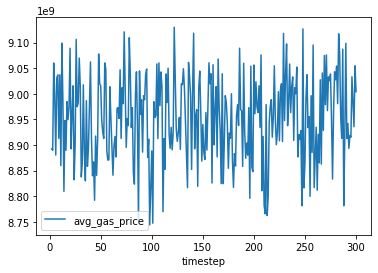

In [13]:
df1[df1.timestep > 1].plot("timestep", "avg_gas_price")

{'bodies': [<matplotlib.collections.PolyCollection at 0x191ea79c5c8>],
 'cmaxes': <matplotlib.collections.LineCollection at 0x191e6a73788>,
 'cmins': <matplotlib.collections.LineCollection at 0x191e6b36ac8>,
 'cbars': <matplotlib.collections.LineCollection at 0x191e6bb36c8>}

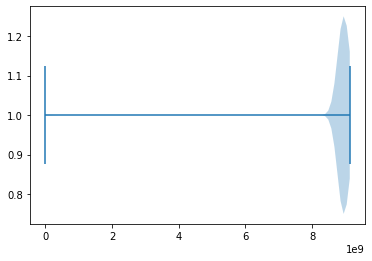

In [14]:
plt.violinplot(df1['avg_gas_price'], vert = False)

We see that for most blocks the average gas-price lies roughly in the range of $8.5*10^{9}$ and $9.0*10^{9}$. It is also clear that there is no congestion control implemented in the system and the entire transaction fee market is entirely dependent and regulated by user bids. 

Now, taking a look at the gas prices with the new upgrade to **EIP-1559**

<AxesSubplot:xlabel='timestep'>

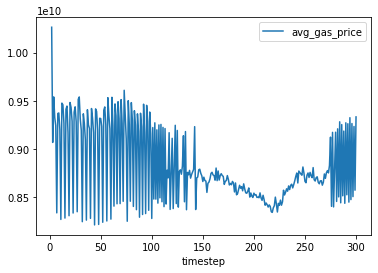

In [16]:
df2[df2.timestep > 1].plot("timestep", "avg_gas_price")

{'bodies': [<matplotlib.collections.PolyCollection at 0x191f4e78688>],
 'cmaxes': <matplotlib.collections.LineCollection at 0x191f446a748>,
 'cmins': <matplotlib.collections.LineCollection at 0x191f46c2288>,
 'cbars': <matplotlib.collections.LineCollection at 0x191f43d3608>}

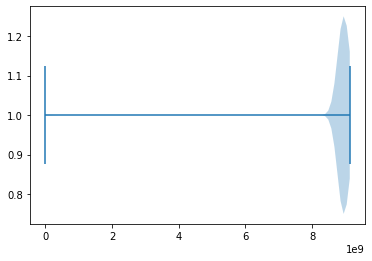

In [17]:
plt.violinplot(df1['avg_gas_price'], vert = False)

While we see similar ranges for the gas prices with the upgrade, one thing that is very interesting here is that in the initial timesteps we see violent fluctuations in the average gas price till it eventually settles into a more "steady state". 

The violent fluctuation is potentially the result of the congestion control set in place. When there is a high demand and the previous block includes many transactions, the basefee is expected to increase thereby increasing the threshold for transaction inclusion (Since now, the transactions whose max fee is lesser than the basefee cannot be included in the next block).

One drawback of our model is that we could not provide a robust quantification on the predictability of the gas price. Therefore we cannot evaluvate how well this objective of the new proposal is met. We propose to add this to our future work. 

### Basefee, Max-fee and Tip

Let us now see how the basefee behaves and the ranges for the max fee and tip

<AxesSubplot:xlabel='timestep'>

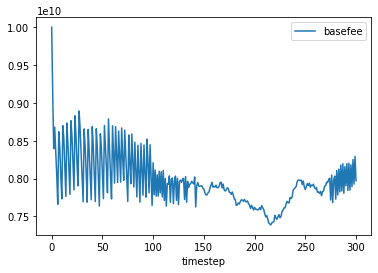

In [18]:
df2.plot('timestep', ['basefee'])

We see that the basefee also shows a similar behaviour of fluctuating before settling down to a steady state. Seeing the similarities in the trend with just a difference in the range could suggest that the basefee could be used as a good metric to determine how much a user should pay to get their transaction included on chain. This could potentially mean that, as intended, the gas prices have become more predictable (However our model still does not capture any concrete evidence of this)

In [19]:
df2["avg_tip"] = df2.latest_block.apply(
    lambda block: pd.Series([tx.premium for tx in block.transactions]).mean()
)

df2["avg_max_fee"] = df2.latest_block.apply(
    lambda block: pd.Series([tx.fee_cap for tx in block.transactions]).mean()
)

df2["avg_max_fee"] = df2["avg_max_fee"].fillna(0)
df2["avg_tip"] = df2["avg_tip"].fillna(0)

ipykernel_launcher:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
ipykernel_launcher:6: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


<AxesSubplot:>

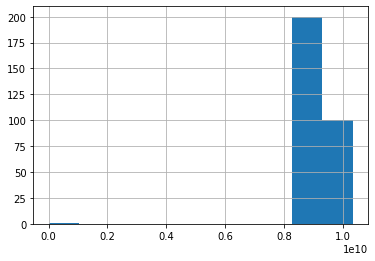

In [20]:
df2["avg_max_fee"].hist(bins = 10)

<AxesSubplot:>

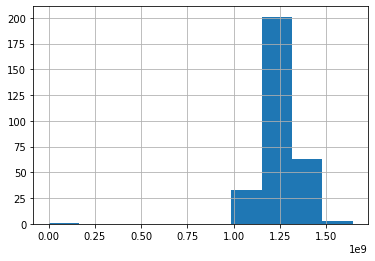

In [21]:
df2["avg_tip"].hist(bins = 10)

We notice that the range of the average max fee is similar to that of the average basee fee, which is as expected, and that for the transactions which were included in the blocks, the average tip was mostly between ($1*10^{9}$ to $1.5*10^{9}$)

### Block sizes

As mentioned earlier, one of the biggest critique to the new system is that it is theorized that the block sizes would show a very high variance. We would like to primarily see if this is true especially in comparision to the old system.

Let us start by plotting the block sizes for the legacy case

<AxesSubplot:xlabel='timestep'>

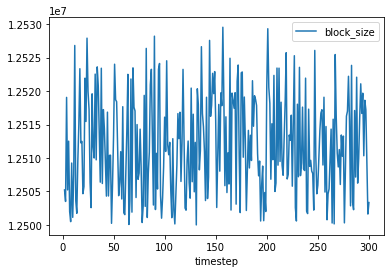

In [22]:
df1[df1.timestep > 1].plot("timestep", "block_size")

Now let us see how it looks for the case of EIP 1559

<AxesSubplot:xlabel='timestep'>

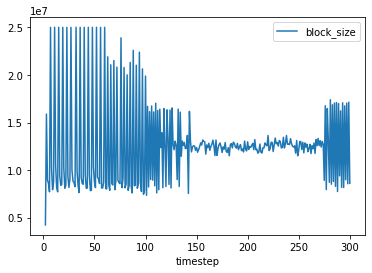

In [23]:
df2[df2.timestep > 1].plot("timestep", "block_size")

We clearly see that the block size variance is much higher for the case of EIP-1559. This is infact a red flag, since block size variance, unlike other metrics, can potentially harm the the nodes that are connected to the network since processing larger blocks require higher computational power. Thus, having such fluctuations is not a good sign. If we were to compare just how much larger is the block size variance is in the case of EIP-1559, it would be:

In [24]:
print(df2['block_size'].var()/df1['block_size'].var())

35.911031771110004


## Output Analysis 

### Blocksize

We now wish to analyze if the long term average block size after EIP-1559 is close to the target. 

We do so by simulating 5 runs of the EIP-1559 simulation and taking the average for each run. We finally take the average of the means that we obtained from each of the 5 runs.

(The reason we simulate very less is due to the computational power required to run many simulation rounds)

In [25]:
def simulate_once_eip1559():
    
    rand = []
    rand_lst = []

    for i in range(1000000):
        a = random.randint(0,2)
        b = a + random.randint(1,9)
        c = random.randint(20000,30000)
    
        rand.append((a,b))
        rand_lst.append(c)
        
    psub = [{
        "policies": {},
        "variables": {
            "demand": demand_functions_eip1559 # step 1
        }
    }, {
        "policies": {
            "action": transaction_selection_eip1559 # step 2
        },
        "variables": {
            "basefee": update_basefee, # step 3
            "latest_block": record_latest_block ,
            "n_row": update_nrow
        }
    }]

    initial_state = {
        "demand": {},
        "latest_block": block(size = 0, transactions=[], avg_gas_price = 0),
        "basefee": 10 * (10 ** 9),
        "n_row":0
    }

    blocks = 300

    model = Model(
        initial_state=initial_state,
        state_update_blocks=psub,
    )
    simulation = Simulation(model=model, timesteps=blocks, runs=1)
    experiment = Experiment([simulation])
    experiment.engine = Engine(deepcopy=False, drop_substeps=True)
    result = experiment.run()
    df = pd.DataFrame(result)
    
    df['block_size'] = df.latest_block.apply(
    lambda block: block.size)
      
    return(df['block_size'].mean())
    

# Collecting the results from 100 simulation runs 

simulation_run_list = []

for i in range(5):
    simulation_run_list.append([simulate_once_eip1559()])

In [58]:
simulation_run_list = np.array(simulation_run_list)
#print("The average block sizes for each of the 10 simulations are recorded as {}".format(simulation_run_list))
print("The target size is {}".format(constants_eip1559["TARGET_SIZE"]))
print("The average of the average block size after 5 runs is {} ".format(simulation_run_list.mean()))

The target size is 12500000
The average of the average block size after 5 runs is 12460185.810631229 


In [59]:
diff = abs((simulation_run_list.mean() - constants_eip1559["TARGET_SIZE"]))
per_diff = (diff/constants_eip1559["TARGET_SIZE"])*100

print("The difference form the target size is {} ".format(diff))
print("The percentage by which it is off from the target size is {} ".format(per_diff))

The difference form the target size is 39814.18936877139 
The percentage by which it is off from the target size is 0.3185135149501711 


As we can see, the average block size is very close to the intended target value of 12500000.

### Economic value captured by the network

Now, we wish to estimate of the economic value that was captured by the use of the network, by taking the average basefee over 5 simulation runs and then finding the average of that. 

In [60]:
def simulate_once_eip1559():
    
    rand = []
    rand_lst = []

    for i in range(1000000):
        a = random.randint(0,2)
        b = a + random.randint(1,9)
        c = random.randint(20000,30000)
    
        rand.append((a,b))
        rand_lst.append(c)
        

    psub = [{
        "policies": {},
        "variables": {
            "demand": demand_functions_eip1559 # step 1
        }
    }, {
        "policies": {
            "action": transaction_selection_eip1559 # step 2
        },
        "variables": {
            "basefee": update_basefee, # step 3
            "latest_block": record_latest_block ,
            "n_row": update_nrow
        }
    }]

    initial_state = {
        "demand": {},
        "latest_block": block(size = 0, transactions=[], avg_gas_price = 0),
        "basefee": 10 * (10 ** 9),
        "n_row":0
    }

    blocks = 300

    model = Model(
        initial_state=initial_state,
        state_update_blocks=psub,
    )
    simulation = Simulation(model=model, timesteps=blocks, runs=1)
    experiment = Experiment([simulation])
    experiment.engine = Engine(deepcopy=False, drop_substeps=True)
    result = experiment.run()
    df = pd.DataFrame(result)
    
    return(df['basefee'].mean())
    

# Collecting the results from 100 simulation runs 

simulation_run_list = []

for i in range(5):
    simulation_run_list.append([simulate_once_eip1559()])

In [61]:
simulation_run_list = np.array(simulation_run_list)
print("The average of the average basefee after 5 runs is {} ".format(simulation_run_list.mean()))

The average of the average basefee after 5 runs is 7975142266.252492 


## Running Simulation with real time data

### Rationale

- In the previous section for, we used randomly generated transactions to run and compare between legacy and EIP1559 model. 
- In reality, users make a more calculated decision while submitting their transactions to the Blockchain, thus we also wanted to see how the simulation performs under real time data from the Ethereum blockchain
- We tried to call an external api from [BlockCypher](https://www.blockcypher.com/) that that draws out pending transactions from realtime Ethereum's MEMPOOL
- Running the simulation alongside with calling external api simultaneously takes sometime (roughly an hour)
- Hence, we decided for simplicity sake, we will create a real time transactions dataset by calling the external api seperately to save time for grading

### Dataset : realtxndata.csv
- Collected transactional data in real time for 300 timesteps on 1/12/2021 from around 12.35pm to 1.10pm 
- 9 columns=['total','fees','size','gas_limit','gas_price','gas_tip_cap','gas_fee_cap','received','timestep']
- only ['gas_limit','gas_tip_cap','gas_fee_cap','timestep'] are used in the code
- 449639 rows
- We also find out the initial base fee through calling another external api from [etherscan](https://etherscan.io/) at t=0 which we found out to be **120.53390394**

**Reference Code on how we created the dataset, no need to run this part below**

In [ ]:
# collect realtime data 
import pandas as pd
import json
import requests
import numpy as np

# start up Amazon AWS api gateway service ----> this is to workaround api call limits through ip rotation
from requests_ip_rotator import ApiGateway, EXTRA_REGIONS
gateway = ApiGateway("https://api.blockcypher.com",access_key_id = 'xxxxxxxxxxxxxxxx', access_key_secret = 'xxxxxxxxxxxxxxxxxxx') # api keys not included since it is private
gateway.start() # start up aws api gateway
session = requests.Session()
session.mount("https://api.blockcypher.com", gateway)

def grab_txns_one_block(timestep):
    block_txns = pd.DataFrame(columns=['total','fees','size','gas_limit','gas_price','gas_tip_cap','gas_fee_cap','received','timestep'])
    for i in range(15):
        pendingtxns = session.get('https://api.blockcypher.com/v1/eth/main/txs?limit=100') # call blockcypher api to get pending transactions from real time ethereum mempool
        data = pd.DataFrame.from_dict(json.loads(pendingtxns.content), orient='columns').iloc[:,4:12]
        data['timestep'] = np.linspace(timestep,timestep,len(data)) # during each call, not every call gives full 100 transactions, hence len(data is used)
        block_txns = block_txns.append(data,ignore_index=True)
    return block_txns

realtime_txns = pd.DataFrame(columns=['total','fees','size','gas_limit','gas_price','gas_tip_cap','gas_fee_cap','received','timestep'])
basefee = requests.get('https://api.etherscan.io/api?module=gastracker&action=gasoracle&apikey=YourApiKeyToken').content # call etherscan api to get current base fee of ethereum network
realtime_basefee = float(json.loads(basefee)['result']['suggestBaseFee'])

for i in range(300): # get txns for 300 timesteps
    timestep = i
    realtime_txns = realtime_txns.append(grab_txns_one_block(timestep),ignore_index=True)

gateway.shutdown() # shutdown aws api gateway

realtime_txns.to_csv('realtxndata.csv') # create dataset

**START RUNNING FROM HERE**

In [6]:
## Functions 
%cd abm1559/sma_project
realtxndata = pd.read_csv('realtxndata.csv') # import dataset

def demand_functions_eip1559(params, substep, state_history, previous_state, policy_input):
    
    demand_dict = previous_state['demand']
    previous_block = previous_state["latest_block"]
    
    real_data = realtxndata[realtxndata['timestep']==previous_state['timestep']] # get transactions tagged to current timestep

    if len(previous_block.transactions) > 0:     # remove transactions that have already been processed in previous block
        for tx in previous_block.transactions:
            demand_dict.pop(tx.transaction_hash)
    
    for _,row in real_data.iterrows():
        tx = eip1559_transaction(
            total_gas = row['gas_limit'],
            premium = row['gas_tip_cap'],
            fee_cap = row['gas_fee_cap']
        )
        demand_dict[tx.transaction_hash] = tx
        
        #print("New transaction {}, submitted into the mempool".format(tx.transaction_hash))
    
    return ("demand", demand_dict)

def demand_functions_legacy(params, substep, state_history, previous_state, policy_input):
    
    demand_dict = previous_state['demand']
    previous_block = previous_state["latest_block"]
    
    real_data = realtxndata[realtxndata['timestep']==previous_state['timestep']] # get transactions tagged to current timestep
    
    if len(previous_block.transactions) > 0: # remove transactions that have already been processed in previous block
        for tx in previous_block.transactions: 
            demand_dict.pop(tx.transaction_hash)
    
    for _,row in real_data.iterrows():
        tx = legacy_transaction(
            total_gas = row['gas_limit'],
            fee = row['gas_fee_cap']
        )
        demand_dict[tx.transaction_hash] = tx
        
        #print("New transaction {}, submitted into the mempool".format(tx.transaction_hash))
    
    return ("demand", demand_dict)


def transaction_selection_eip1559(params, substep, state_history, previous_state):
    
    demand_dict = previous_state["demand"] #simulates the MEMPOOL which is also the demand_dict returned at demand_function_eip
    basefee = previous_state["basefee"]
    
    size = constants_eip1559["MAX_BLOCK_SIZE"]
    final_fee_transactions = {}
    final_gas_prices = {}
    
    for i in demand_dict.keys():
        if basefee > demand_dict[i].fee_cap:
            continue
        else:
            final_fee_transactions[i] = (min(demand_dict[i].fee_cap - basefee, demand_dict[i].premium))/demand_dict[i].total_gas_used
            final_gas_prices[i] = min(basefee + demand_dict[i].premium, demand_dict[i].fee_cap)
            
    final_fee_transactions = dict(sorted(final_fee_transactions.items(), key=lambda x: x[1], reverse=True))
    
    included_transactions = []
    total_size_used = 0
    gas_fee_total = []
    
    for i in final_fee_transactions.keys():
        
        if total_size_used < size:
            included_transactions += [demand_dict[i]]
            total_size_used += demand_dict[i].total_gas_used
            gas_fee_total.append(final_gas_prices[i])
        
    print("{} Number of transactions being included in the next block".format(len(included_transactions)))
    
    if(len(gas_fee_total) == 0):
        avg_gas_price = 0
    else:
        avg_gas_price = sum(gas_fee_total)/len(gas_fee_total)
        
    return { "block": block(size = total_size_used, transactions = included_transactions, avg_gas_price = avg_gas_price)}
        
def transaction_selection_legacy(params, substep, state_history, previous_state):
    
    demand_dict = previous_state["demand"] #simulates the MEMPOOL which is also the demand_dict returned at demand_function_legacy
    
    size = constants_legacy["MAX_BLOCK_SIZE"]
    final_fee_transactions = {}
    
    for i in demand_dict.keys():
            final_fee_transactions[i] =  (demand_dict[i].fee/demand_dict[i].total_gas_used)    
            
    final_fee_transactions = dict(sorted(final_fee_transactions.items(), key=lambda x: x[1], reverse=True))
    
    included_transactions = []
    total_size_used = 0
    gas_fee_total = []                     
    
    for i in final_fee_transactions.keys():
        
        if total_size_used < size:
            included_transactions += [demand_dict[i]]
            total_size_used += demand_dict[i].total_gas_used
            gas_fee_total.append(demand_dict[i].fee)
          
    print("{} Number of transactions being included in the next block".format(len(included_transactions)))
        
    return { "block": block(size = total_size_used, transactions = included_transactions, avg_gas_price = sum(gas_fee_total)/len(gas_fee_total)) }
        
def update_basefee(params, substep, state_history, previous_state, policy_input):
    
    gas_used = sum([i.total_gas_used for i in policy_input["block"].transactions])
    basefee = previous_state["basefee"]
    
    basefee = basefee + basefee * (gas_used - constants_eip1559["TARGET_SIZE"]) // constants_eip1559["TARGET_SIZE"] // constants_eip1559["BASEFEE_MAX_CHANGE_DENOMINATOR"]
    
    print("The new basefee is: {}".format(basefee))
          
    return ("basefee", basefee)


def record_latest_block(params, substep, state_history, previous_state, policy_input):
    
    block = policy_input["block"]
          
    print("New block recorded")
    
    return ("latest_block", block)

c:\Users\Admin\Desktop\SUTD\ESD\T6\SMA\abm1559\sma_project\abm1559\sma_project


### Legacy

In [7]:
psub = [{
    "policies": {},
    "variables": {
        "demand": demand_functions_legacy # step 1
    }
}, {
    "policies": {
        "action": transaction_selection_legacy # step 2
    },
    "variables": {
        "latest_block": record_latest_block # step 3
    }
}]

initial_state = {
    "demand": {},
    "latest_block": block(size = 0, transactions=[], avg_gas_price = 0)
}

blocks = 300

model = Model(
    initial_state=initial_state,
    state_update_blocks=psub,
)
simulation = Simulation(model=model, timesteps=blocks, runs=1)
experiment = Experiment([simulation])
experiment.engine = Engine(deepcopy=False, drop_substeps=True)
result = experiment.run()
df3 = pd.DataFrame(result) #experimental result

### EIP1559

In [8]:
psub = [{
    "policies": {},
    "variables": {
        "demand": demand_functions_eip1559 # step 1
    }
}, {
    "policies": {
        "action": transaction_selection_eip1559 # step 2
    },
    "variables": {
        "basefee": update_basefee, # step 3
        "latest_block": record_latest_block # step 3 too
    }
}]

initial_state = {
    "demand": {},
    "latest_block": block(size = 0, transactions=[], avg_gas_price = 0),
    "basefee": 120.53390394 * (10 ** 9) # we use the initial real time basefee we found out when we created data at t=0!
}

blocks = 300

model = Model(
    initial_state=initial_state,
    state_update_blocks=psub,
)
simulation = Simulation(model=model, timesteps=blocks, runs=1)
experiment = Experiment([simulation])
experiment.engine = Engine(deepcopy=False, drop_substeps=True)
result = experiment.run()
df4 = pd.DataFrame(result) #experimental result

### Preprocessing of Data (with realtime data)

In [9]:
df3["txs_per_block"] = df3.latest_block.apply(
    lambda block: len(block.transactions)
)
df3['block_size'] = df3.latest_block.apply(
    lambda block: block.size
)
df3['avg_gas_price'] = df3.latest_block.apply(
    lambda block: block.avg_gas_price
)



df4["txs_per_block"] = df4.latest_block.apply(
    lambda block: len(block.transactions)
)
df4['block_size'] = df4.latest_block.apply(
    lambda block: block.size
)
df4['avg_gas_price'] = df4.latest_block.apply(
    lambda block: block.avg_gas_price
)

N = 5
# Drop first N columns of dataframe
df_legacy_real = df3.iloc[: , N:]
df_eip1559_real = df4.iloc[: , N:]
df_eip1559_real['basefee'] = df4['basefee']

df_legacy_real['gas_price_diff'] = df_legacy_real['avg_gas_price'].diff().abs()
df_eip1559_real['gas_price_diff'] = df_eip1559_real['avg_gas_price'].diff().abs()

### Legacy results under real time data

In [9]:
df_legacy_real

,substep,timestep,txs_per_block,block_size,avg_gas_price,gas_price_diff
0,0,0,0,0,0.000000e+00,NaN
1,2,1,376,12520266,8.264730e+06,8.264730e+06
2,2,2,465,12518824,7.996072e+06,2.686579e+05
3,2,3,454,12516781,7.290266e+06,7.058069e+05
4,2,4,488,12510765,6.872772e+06,4.174936e+05
...,...,...,...,...,...,...
296,2,296,358,12523167,7.533116e+06,2.254404e+05
297,2,297,471,12515913,7.333468e+06,1.996478e+05
298,2,298,436,12516859,7.709889e+06,3.764215e+05
299,2,299,431,12530540,7.488116e+06,2.217730e+05


### EIP1559 results under real time data

In [10]:
df_eip1559_real

,run,substep,timestep,txs_per_block,block_size,avg_gas_price,basefee,gas_price_diff
0,1,0,0,0,0,0.000000e+00,1.205339e+11,NaN
1,1,2,1,239,25192497,1.770309e+11,1.358327e+11,1.770309e+11
2,1,2,2,302,25150242,1.687834e+11,1.530158e+11,8.247494e+09
3,1,2,3,703,25862846,1.579512e+11,1.734631e+11,1.083228e+10
4,1,2,4,266,25001482,1.791539e+11,1.951486e+11,2.120272e+10
...,...,...,...,...,...,...,...,...
296,1,2,296,92,25243510,3.026622e+11,3.390397e+11,4.027055e+10
297,1,2,297,33,10673180,3.421288e+11,3.328460e+11,3.946658e+10
298,1,2,298,43,9032838,3.387798e+11,3.213057e+11,3.349024e+09
299,1,2,299,41,13601970,3.244488e+11,3.248464e+11,1.433097e+10


## Plots and Visualisations

### Gas Prices

Let us first look at the evolution of the gas price in the **legacy case under real time data**

### Legacy

<AxesSubplot:xlabel='timestep'>

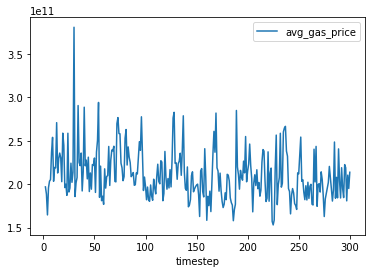

In [10]:
df_legacy_real[df_legacy_real.timestep > 1].plot("timestep", "avg_gas_price")

{'bodies': [<matplotlib.collections.PolyCollection at 0x2457c676f88>],
 'cmaxes': <matplotlib.collections.LineCollection at 0x2457fca9c88>,
 'cmins': <matplotlib.collections.LineCollection at 0x24576606648>,
 'cbars': <matplotlib.collections.LineCollection at 0x245005185c8>}

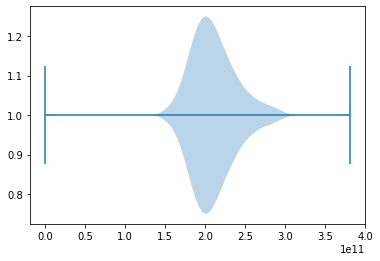

In [11]:
plt.violinplot(df_legacy_real['avg_gas_price'], vert = False)

Under realtime dataset, we see for most blocks the average gas-price lies roughly in the range of 
$1.5*10^{11}$ and $3.0*10^{11}$ . We also observe that average gas prices across the time period is very volatile, once more indicating that there is no congestion control implemented in the system and the entire transaction fee market is entirely dependent and regulated by user bids, the first price auction method.

Now, we take a look at gas prices under the **EIP-1559** model

### eip1559

<AxesSubplot:xlabel='timestep'>

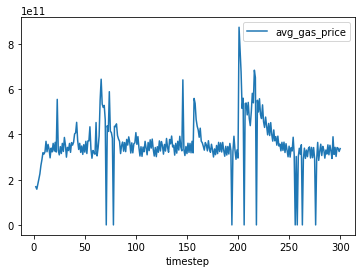

In [13]:
df_eip1559_real[df_eip1559_real.timestep > 1].plot("timestep", "avg_gas_price")

{'bodies': [<matplotlib.collections.PolyCollection at 0x1f803804f88>],
 'cmaxes': <matplotlib.collections.LineCollection at 0x1f804230288>,
 'cmins': <matplotlib.collections.LineCollection at 0x1f803779fc8>,
 'cbars': <matplotlib.collections.LineCollection at 0x1f803779408>}

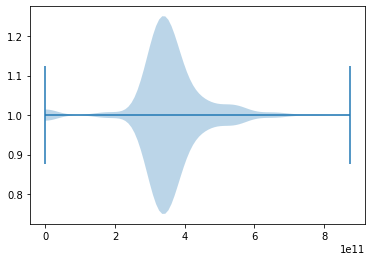

In [14]:
plt.violinplot(df_eip1559_real['avg_gas_price'], vert = False)

Under realtime dataset, we see for most blocks the average gas-price lies roughly in the range of 
$2*10^{11}$ and $6*10^{11}$ , which is of higher range than that of the legacy model. However, we start to notice here that average gas prices tend to be **more stable and less volatile too**, albeit with a few instances of violent fluctuation that is potentially the result of congestion control when demand on network increases.

## Basefee, Max-fee, Tip

Let us now see how basefee behaves and the ranges for max fee and tip

<AxesSubplot:xlabel='timestep'>

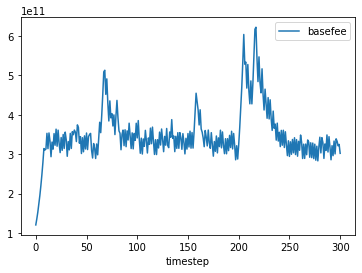

In [32]:
df_eip1559_real.plot('timestep', ['basefee'])

We can definitely observe that there is a sharp upwards spike in basefee before it settles down to a certain range. There are sudden spikes in base fee too (3 in total) after the initial upward spike which could be attributed to higher demand, coincidentally the 3 spikes also coincide with the sharp spikes in average gas price in the same time period. This again is support that the base fee for most of the time can be more predictable under realistic demand. (However, we still cannot concluded anything concrete)

In [36]:
df4["avg_tip"] = df4.latest_block.apply(
    lambda block: pd.Series([tx.premium for tx in block.transactions]).mean()
)

df4["avg_max_fee"] = df4.latest_block.apply(
    lambda block: pd.Series([tx.fee_cap for tx in block.transactions]).mean()
)

df4["avg_max_fee"] = df4["avg_max_fee"].fillna(0)
df4["avg_tip"] = df4["avg_tip"].fillna(0)

C:\Users\Admin\anaconda3\envs\sma\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  
C:\Users\Admin\anaconda3\envs\sma\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  


Text(0.5, 1.0, 'Histogram of avg_max_fee under EIP1559 (realtime data)')

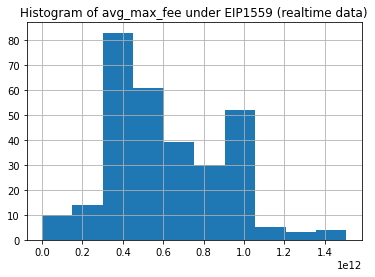

In [37]:
df4["avg_max_fee"].hist(bins = 10)
plt.title('Histogram of avg_max_fee under EIP1559 (realtime data)')

Text(0.5, 1.0, 'Histogram of avg_tip under EIP1559 (realtime data)')

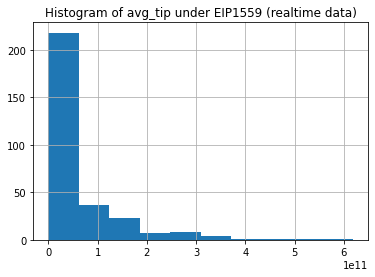

In [38]:
df4["avg_tip"].hist(bins = 10)
plt.title('Histogram of avg_tip under EIP1559 (realtime data)')

We also notice that the range of the average max fee is similar to that of the average basee fee under realistic demand dataset, which is as expected, and that for the transactions which were included in the blocks, the average tip was mostly seems to be exponentially distributed between ($0*10^{11}$ to $4*10^{11}$)

### Block Sizes

We will now compare block size changes for both models under realistic demand.

Let is start by plotting the block sizes for the legacy case

### Legacy

<AxesSubplot:xlabel='timestep'>

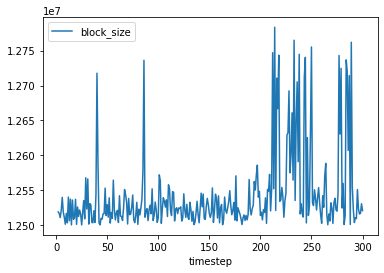

In [12]:
df_legacy_real[df_legacy_real.timestep > 1].plot("timestep", "block_size")

Now like us see how it looks like for EIP1559 case

### eip1559

<AxesSubplot:xlabel='timestep'>

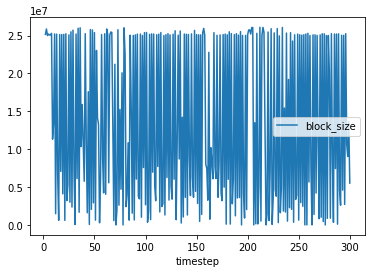

In [28]:
df_eip1559_real[df_eip1559_real.timestep > 1].plot("timestep", "block_size")

In [13]:
print("The variance after eip1559 is {} times higher than in the legacy case".format(df_eip1559_real['block_size'].var()/df_legacy_real['block_size'].var()))

The variance after eip1559 is 219.55578252895552 times higher than in the legacy case


We can clearly once again see that block size variance is much higher for EIP1559 under realistic demand than the legacy model. We see violent osscilations between the two extreme cases (fully filled vs empty blocks), which is truly concerning. 